# Market Regime Detection using Hidden Markov Models (HMM)
## Quantitative Trading System (NIFTY – Daily)

This notebook implements a **Hidden Markov Model (HMM)** to classify
market conditions into three regimes using **options-based features only**.

### Tasks Covered
- Task 3.1: HMM Implementation
- Task 3.2: Regime Visualization

### Regimes
- Regime +1: Uptrend
- Regime -1: Downtrend
- Regime 0: Sideways

### Input Dataset
- nifty_features_daily.csv

### Output
- Regime labels
- Regime visualizations


In [27]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

In [28]:
df = pd.read_csv("nifty_features_daily.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

df.head()

,date,open_spot,high_spot,low_spot,close_spot,volume_spot,open_fut,high_fut,low_fut,close_fut,...,put_rho,avg_iv,iv_spread,pcr_oi,pcr_vol,futures_basis,spot_return,fut_return,delta_neutral_ratio,gamma_exposure
0,2025-01-15,23250.45,23293.65,23146.45,23213.20,228039156,23302.05,23345.00,23201.00,23265.90,...,8.709732,0.878341,0.0,0.853403,1.102955,0.002270,0.001603,-0.000251,1.269496,6.012549e+07
1,2025-01-16,23377.25,23391.65,23272.05,23311.80,299416081,23406.00,23423.90,23346.15,23377.55,...,8.745398,0.878341,0.0,0.847039,0.921457,0.002820,0.004248,0.004799,1.268992,1.034832e+08
2,2025-01-17,23277.10,23292.10,23100.35,23203.20,272945267,23344.90,23353.80,23150.10,23267.20,...,8.696853,0.878341,0.0,1.054174,1.158159,0.002758,-0.004659,-0.004720,1.266024,1.589183e+07
3,2025-01-20,23290.40,23391.10,23170.65,23344.75,301455455,23339.95,23449.00,23220.00,23400.20,...,8.742171,0.878341,0.0,0.982243,0.714776,0.002375,0.006100,0.005716,1.263108,1.763011e+07
4,2025-01-21,23421.65,23426.30,22976.85,23024.65,312871897,23424.95,23460.65,23051.65,23103.20,...,8.649537,0.878341,0.0,1.794741,4.934940,0.003412,-0.013712,-0.012692,1.273557,1.147094e+07


In [29]:
hmm_features = [
    'avg_iv',
    'iv_spread',
    'pcr_oi',
    'call_delta',
    'call_gamma',
    'call_vega',
    'futures_basis',
    'spot_return'
]

X = df[hmm_features].values

In [30]:
train_size = int(0.7 * len(X))

X_train = X[:train_size]
X_test  = X[train_size:]

In [31]:
MODEL_PATH = "/content/hmm_regime_model.pkl"

if os.path.exists(MODEL_PATH):
    print("✅ Loading existing HMM model...")
    hmm = joblib.load(MODEL_PATH)

else:
    print("🚀 Training new HMM model...")

    train_size = int(0.7 * len(X))
    X_train = X[:train_size]

    hmm = GaussianHMM(
        n_components=3,
        covariance_type="full",
        n_iter=500,
        random_state=42
    )

    hmm.fit(X_train)

    joblib.dump(hmm, MODEL_PATH)
    print(f"💾 HMM model saved to {MODEL_PATH}")

✅ Loading existing HMM model...


In [32]:
hidden_states = hmm.predict(X)
df['regime_raw'] = hidden_states

In [33]:
state_returns = df.groupby('regime_raw')['spot_return'].mean()
state_returns

,spot_return
regime_raw,
0,0.000683
1,0.000723
2,-0.000451


In [34]:
regime_map = {
    state_returns.idxmax():  1,   # Uptrend
    state_returns.idxmin(): -1,   # Downtrend
    [s for s in state_returns.index if s not in [state_returns.idxmax(), state_returns.idxmin()]][0]: 0
}

df['regime'] = df['regime_raw'].map(regime_map)

In [35]:
df['regime'].value_counts(normalize=True) * 100

,proportion
regime,
1,38.709677
0,38.306452
-1,22.983871


In [36]:
import joblib
joblib.dump(hmm, "hmm_regime_model.pkl")

['hmm_regime_model.pkl']



---



# REGIME VISUALIZATION

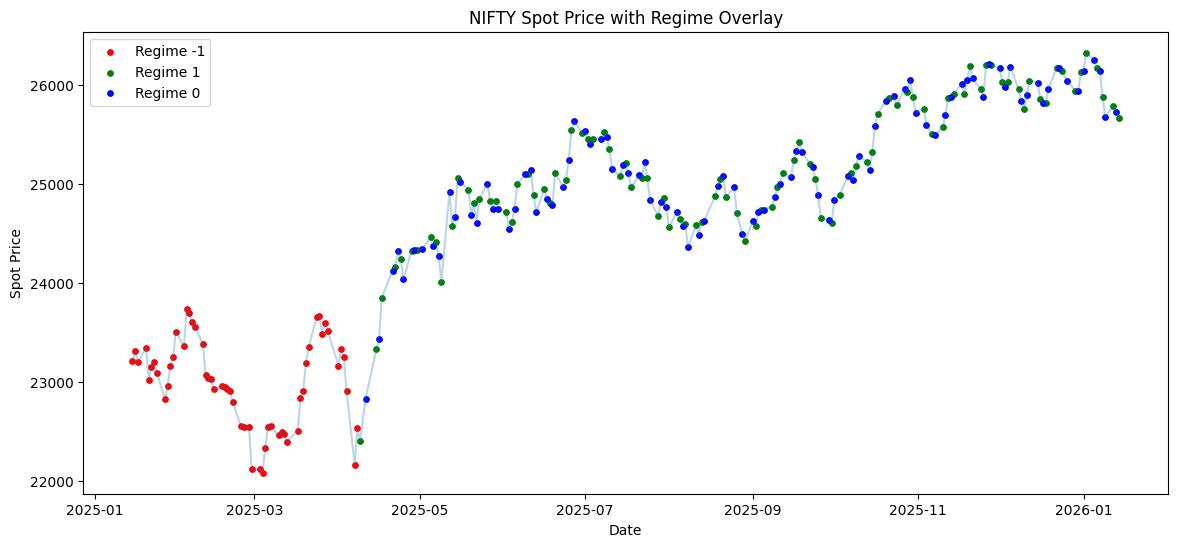

In [37]:
plt.figure(figsize=(14,6))

colors = {1: 'green', 0: 'blue', -1: 'red'}

for regime in df['regime'].unique():
    subset = df[df['regime'] == regime]
    plt.scatter(
        subset['date'],
        subset['close_spot'],
        color=colors[regime],
        label=f"Regime {regime}",
        s=15
    )

plt.plot(df['date'], df['close_spot'], alpha=0.3)
plt.legend()
plt.title("NIFTY Spot Price with Regime Overlay")
plt.xlabel("Date")
plt.ylabel("Spot Price")
plt.show()

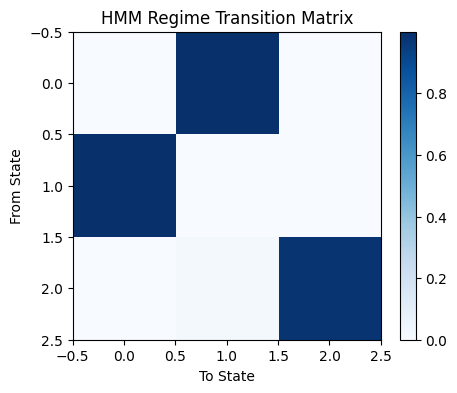

In [38]:
trans_mat = hmm.transmat_

plt.figure(figsize=(5,4))
plt.imshow(trans_mat, cmap='Blues')
plt.colorbar()

plt.title("HMM Regime Transition Matrix")
plt.xlabel("To State")
plt.ylabel("From State")

plt.show()

In [39]:
regime_stats = df.groupby('regime')[[
    'avg_iv',
    'call_delta',
    'call_gamma',
    'call_vega'
]].mean()

regime_stats

,avg_iv,call_delta,call_gamma,call_vega
regime,,,,
-1,0.706451,0.551155,0.000087,26.077409
0,0.562851,0.546399,0.000107,28.599250
1,0.562238,0.546690,0.000107,28.585300


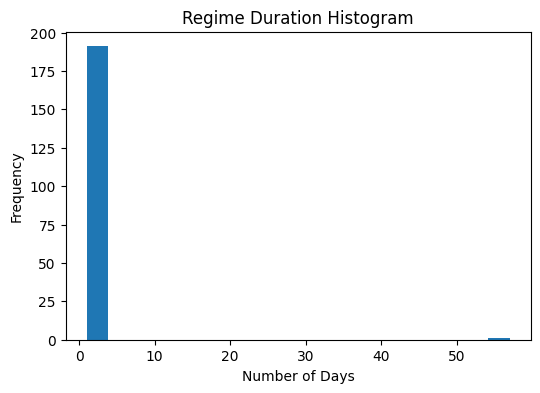

In [40]:
df['regime_change'] = df['regime'].ne(df['regime'].shift())
df['regime_group'] = df['regime_change'].cumsum()

durations = df.groupby('regime_group').size()

plt.figure(figsize=(6,4))
plt.hist(durations, bins=20)
plt.title("Regime Duration Histogram")
plt.xlabel("Number of Days")
plt.ylabel("Frequency")
plt.show()

## Regime Detection Summary

- Model: Hidden Markov Model (Gaussian)
- States: 3
- Training Data: First 70%
- Features: Options-based + futures basis + spot returns

### Identified Regimes
- +1: Uptrend (positive average returns)
- -1: Downtrend (negative average returns)
- 0: Sideways (low return magnitude)

### Usage in Trading System
- Regime-aware strategy selection
- Risk management and position sizing
- Filtering false signals in sideways markets




---



In [41]:
df[['date', 'regime']].to_csv("nifty_regimes_daily.csv", index=False)